In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#pip install wandb

Create a siamese network for immage classification

In [4]:
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm as tq
import matplotlib.pyplot as plt
from skimage.io import imshow
from pathlib import Path
import numpy as np
import random
import wandb

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: thomas-borsani1. Use `wandb login --relogin` to force relogin


True

load data

In [6]:
#/content/drive/MyDrive/Colab Notebooks/efficent net/
npz = np.load('../data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


plot some data

In [7]:
# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def plot_image(ix):
    imshow(np.squeeze(X_train[ix,:,:,:]))#Looking at the combined channel
    plt.show()
    labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(Y_train[ix])])

def plot_image_pair(num_img):
    f, axarr = plt.subplots(2)
    axarr[0].imshow(np.squeeze(train_dataset_loader.dataset.right_dat[num_img]))
    axarr[1].imshow(np.squeeze(train_dataset_loader.dataset.left_dat[num_img]))
    plt.show()
    labels = ['equal','not equal']  #0 is no iceberg(ship) and 1 is iceberg
    print ('This is:',labels[int(train_dataset_loader.dataset.targets[num_img])])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


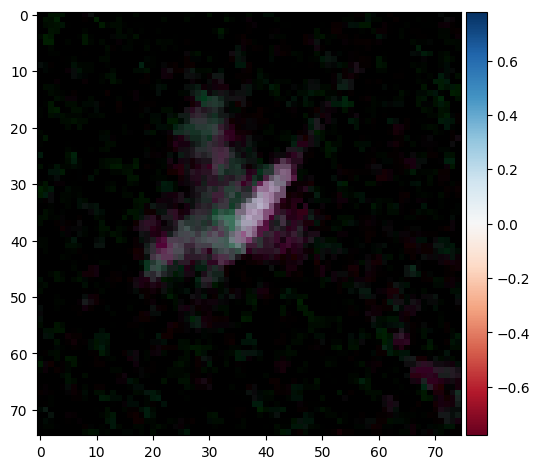

This is: Iceberg


In [8]:
plot_image(101)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


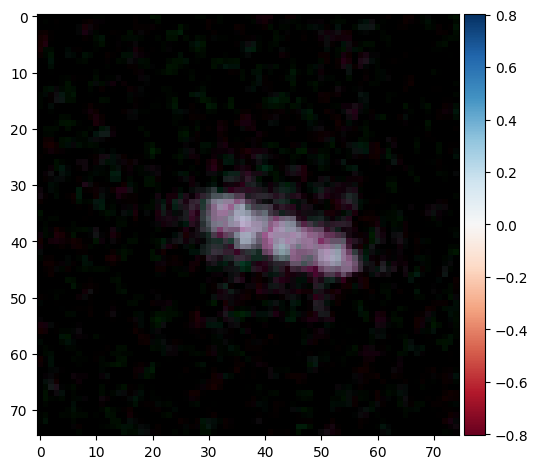

This is: Ship


In [9]:
plot_image(100)

create a base network

In [10]:

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.apply(self._init_weights)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5, 5, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(5,7,3,padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        
        self.fc1=nn.Sequential(
            nn.Linear(2268,18),
            nn.Sigmoid())

        self.out = nn.Linear(18,1)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.2)
            if module.bias is not None:
                module.bias.data.normal_(mean=0.5, std=0.01)
        
    def forward_once(self,inp):
        inp=self.conv(inp)
        inp=self.fc1(inp)
        return inp

    def forward(self, inp1, inp2):
        out1=self.forward_once(inp1)
        out2=self.forward_once(inp2)
        dis=torch.abs(out2-out1)
        out=self.out(dis)
        return out

Create the pair of images to train on

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, left_list, right_list,targets, transform):
        self.left_dat = left_list
        self.right_dat = right_list
        self.targets = targets
        self.transform = transform
        self.imag_nomr = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        left_img = self.left_dat[idx]
        right_img = self.right_dat[idx]
        targets = self.targets[idx]
        
        left_img = np.transpose(left_img,(2,0,1))
        left_img = torch.Tensor(left_img)

        right_img = np.transpose(right_img,(2,0,1))
        right_img = torch.Tensor(right_img)

        # nomalization of immages
        left_img = self.imag_nomr(left_img)
        right_img = self.imag_nomr(right_img)
                        
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
    
        return left_img, right_img, targets




In [12]:
def crate_Pairs_data(image_list,label_list, pairs = 5):
    """

    """
    left_input = []
    right_input = []
    targets = []

    #Number of pairs per image
    pairs = pairs
    #Let's create the new dataset to train on
    for i in range(len(label_list)):
        for _ in range(pairs): 
            # compare the same immage on the left to different immages to the right
            compare_to = i 
            while compare_to == i: #Make sure it's not comparing to itself
                compare_to = random.randint(0,len(image_list)-1)

            left_img = image_list[i][0]
            right_img = image_list[compare_to][0]

            # create data sets
            left_input.append(np.array(left_img))
            right_input.append(np.array(right_img))

            if label_list[i] == label_list[compare_to]:# They are the same
                targets.append(0.)
            else:# Not the same
                targets.append(1.)
    
    return left_input,right_input,targets

In [13]:
X_index, y_index = range(X_train.shape[0]), range(Y_train.shape[0])
# test 20% 
X_train_index, X_test_index, y_train_index, y_test_index = train_test_split(X_index, y_index,
    test_size=0.2, shuffle = True, random_state = 42)

# validation 20% training 60%
X_train_index, X_val_index, y_train_index, y_val_index = train_test_split(X_train_index, y_train_index, 
    test_size=0.20, random_state= 42) # 0.25 x 0.8 = 0.2

In [14]:
len(X_train_index),len(X_val_index),len(X_test_index)


(2632, 658, 823)

Data augemtation

In [15]:
transform = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(0.7),
    transforms.RandomVerticalFlip(0.7),
    transforms.RandomGrayscale(0.7),
    )

Train data

In [16]:
num_workers = 2
bs = 64

In [17]:
image_list_train = np.split(X_train[X_train_index],len(X_train_index))
label_list_train = np.split(Y_train[y_train_index],len(y_train_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_train,label_list=label_list_train,pairs=5)
train_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=transform)


train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=bs,shuffle=False, num_workers=num_workers)

del image_list_train,label_list_train,train_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


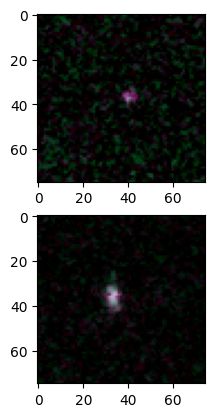

This is: not equal


In [18]:
plot_image_pair(3)

Validation data

In [19]:
image_list_val = np.split(X_train[X_val_index],len(X_val_index))
label_list_val = np.split(Y_train[y_val_index],len(y_val_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_val,label_list=label_list_val,pairs=5)
validation_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

validation_dataset_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)

del image_list_val,label_list_val,validation_dataset

Test data

In [20]:
image_list_test = np.split(X_train[X_test_index],len(X_test_index))
label_list_test = np.split(Y_train[y_test_index],len(y_test_index))
left_dat,right_dat,targets = crate_Pairs_data(image_list = image_list_test,label_list=label_list_test,pairs=5)
test_dataset = CustomImageDataset(left_list=left_dat,right_list=right_dat,targets=targets,transform=None)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1,shuffle=False, num_workers=2)

del image_list_test,label_list_test,test_dataset

In [21]:
del X_train,Y_train

train model

In [22]:
def correct_out(output,label,TrueNegative,FalseNegative,TruePositive,FalsePositive):
    for j in range(output.size(0)):
        if (output[j]>0.5) and (label[j]==1):
            TrueNegative+=1
        elif (output[j]>0.5) and (label[j]==0):
            FalseNegative+=1
        elif (output[j]<0.5) and (label[j]==0):
            TruePositive+=1
        elif (output[j]<0.5) and (label[j]==1):
            FalsePositive+=1

    return TrueNegative,FalseNegative,TruePositive,FalsePositive

In [23]:
def train(net,optimizer,scheduler,epoch,train_dataset_loader,train_on_gpu,criterion):
    """
    ###################
    #   MODEL TRAIN   #
    ###################
    """
    # keep track of training and validation loss
    TN=0
    FN=0
    TP=0
    FP=0
    net.train()
    bar = tq(train_dataset_loader, postfix={"train_loss":0.0})
    config = wandb.config

    for img0, img1, label in bar:
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()
        output = net(img0, img1)

        loss = criterion(output, label.unsqueeze(1))
        loss.backward()
        optimizer.step()

        # stats
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)
       
        bar.set_postfix({"Train loss":loss.item(),
        "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
        "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
        "correct_out":(TN+TP)/total})

    # scheduler
    scheduler.step()
    
    # report stat
    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)
    lr_rate = [param_group['lr'] for param_group in optimizer.param_groups][0]
    train_metrics = {"train/loss": loss.item(),"train/Precision":Pr,"train/Recall":Rec,"train/Jaccard" :Jaccard, 
                       "train/accuracy": Acc,"lr_rate": lr_rate}
    wandb.log({**train_metrics})

    print("Accuracy training loss after {} epochs : {}".format(epoch, Acc))
    

In [24]:
def validation(net,epoch,validation_dataset_loader,train_on_gpu,criterion):
    """
    ######################   
    #  MODEL VALIDATION  #
    ###################### 
    """
    net.eval()
    del img0, img1, label, bar
    TN=0
    FN=0
    TP=0
    FP=0

    with torch.no_grad():
        bar = tq(validation_dataset_loader, postfix={"valid_loss":0.0})
        for img0, img1, label in bar:
            
            if train_on_gpu:
                img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            output = net(img0, img1)
            validation_loss = criterion(output, label.unsqueeze(1))
            
            total = label.size(0)
            TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)

            bar.set_postfix({"Validation loss":validation_loss.item(),
            "Precision":TP / (TP + FP),"Recall":TP /(TP + FN),
            "Accuracy":(TP+TN)/(TP + TN + FN + FP),"Jaccard":TP/(TP + FN + FP),
            "correct_out":(TP+TN)/total})

    Pr = TP / (TP + FP)
    Rec = TP /(TP + FN)
    Acc = (TP+TN)/(TP + TN + FN + FP)
    Jaccard = TP/(TP + FN + FP)

    
    val_metrics = {"val/loss": validation_loss.item(),"val/Precision":Pr,"val/Recall":Rec,"val/Jaccard" :Jaccard, 
                       "val/accuracy": Acc}
    wandb.log({**val_metrics})
    
    print("Average validation loss after {} epochs : {}".format(epoch, Acc))

In [25]:
net = SiameseNetwork()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 2.5e-4 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


train_on_gpu = torch.cuda.is_available()
train_on_gpu

if train_on_gpu:
    net.cuda()

In [26]:
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {
        'goal': 'minimize', 
        'name': 'validation_loss'
		},
    'parameters': {
        'optimizer': {
            'parameters':{
                'lr':{'values': [0.01, 0.001]},
                'weight_decay':{'values': [2.5e-3,2.5e-5 ]}
            }
        }
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project="project-name")

Create sweep with ID: 2c3fojgc
Sweep URL: https://wandb.ai/thomas-borsani1/project-name/sweeps/2c3fojgc


In [27]:
wandb.init(settings=wandb.Settings(start_method="thread"),
           project="siamese_net",
           config={"learning_rate": 0.01,
                   "architecture": "Siamese Network",
                   "dataset": "Iceberg",
                   "epochs": 30,})

In [28]:
n_epochs = 30
def run_model(n_epochs):
    for epoch in range(1, n_epochs+1):
        train(net, optimizer,scheduler, epoch, train_dataset_loader,train_on_gpu,criterion)
        validation(net, validation_dataset_loader,train_on_gpu,criterion)

In [29]:
wandb.agent(sweep_id=sweep_id, function=run_model(n_epochs=30))

  0%|          | 0/206 [00:00<?, ?it/s, train_loss=0]

In [ ]:
#torch.save(net,'/content/drive/MyDrive/Colab Notebooks/efficent net/net')

In [ ]:
net = torch.load('../data/net_87',map_location=torch.device('cpu'))

Evaluate on test set

In [ ]:
result = []

with torch.no_grad():
    net.eval()
    TN=0
    FN=0
    TP=1
    FP=0
    #del img0, img1, label
    print("Testing...")
    bar = tq(test_dataset_loader, postfix={"Accuracy":0.0})
    config = wandb.config
    for img0, img1, label in bar:
        
        if train_on_gpu:
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
        
        output = net(img0, img1)
        
        total = label.size(0)
        TN,FN,TP,FP = correct_out(output,label,TrueNegative=TN,FalseNegative=FN,TruePositive=TP,FalsePositive=FP)
 
            
        Pr = TP / (TP + FP)
        Rec = TP /(TP + FN)
        Acc = (TP+TN)/(TP + TN + FN + FP)
        Jaccard = TP/(TP + FN + FP) 
        bar.set_postfix(ordered_dict={"Accuracy":(Acc)*100})  
        test_metrics = {"test/loss": loss.item(),"test/Precision":Pr,"test/Recall":Rec,"test/Jaccard" :Jaccard, 
                       "test/accuracy": Acc}
    wandb.log({**test_metrics})
print('{} correct predictions out of {}\nAccuracy : {:.2f}\nJaccard : {:.2f}'.format((TP+TN),(TP+TN+FN+FN), (Acc)*100,Jaccard*100))

In [ ]:
def extract_patch_cam(net, img_l,img_r, patch_width, patch_height):
    assert not img_l.shape[-2] % patch_height and not img_l.shape[-1] % patch_width
    with torch.no_grad():
        pred = net(img_l,img_r).max(1)[1].item()  
        num_patches_x = img_l.shape[-2] // patch_height
        num_patches_y = img_l.shape[-1] // patch_width
        ret = torch.zeros(1, num_patches_y, num_patches_x)
        for i in range(num_patches_y):
            for j in range(num_patches_x):
                tmp_imgL = img_l.clone()
                tmp_imgR = img_r.clone()
                tmp_imgL[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                tmp_imgR[:, :, i * patch_height:(i+1) * patch_height, j * patch_width:(j+1) * patch_width] = 0
                ret[:, i, j] = torch.softmax(net(tmp_imgL,tmp_imgR), dim=1)[0, pred].item()
    ret = 1 - ret
    return ret, pred

In [ ]:
classes = ('iceberg','ship')

idx = 0
patch_width = 5
patch_height = 5

upsample_layer_cpu = torch.nn.Upsample(size=(75, 75), mode='bilinear', align_corners=True).cuda()
data = next(iter(test_dataset_loader))
example_l = upsample_layer_cpu(data[0][idx:idx+1]).cuda()
example_r = upsample_layer_cpu(data[1][idx:idx+1]).cuda()
label = data[2][idx:idx+1].item()
heatmap, pred = extract_patch_cam(net, img_l=example_l,img_r=example_r, patch_width=patch_width, patch_height=patch_height)
print(f"Pred: {[pred]}")
print(f"Ground truth: {[label]}")

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2): axes[i].axis("off")
axes[0].imshow(example_l.cpu()[0].permute(1, 2, 0))
axes[1].imshow(example_r.cpu()[0].permute(1, 2, 0))
#axes[2].imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")

PicklingError: Can't pickle <class '__main__.CustomImageDataset'>: it's not the same object as __main__.CustomImageDataset

In [ ]:
def input_to_features(net, x: torch.Tensor) -> torch.Tensor:
    x = net.conv(x)
    return x

def features_to_output(net, x_l: torch.Tensor,x_r : torch.Tensor,) -> torch.Tensor:
    x_l = net.fc1(x_l)
    x_r = net.fc1(x_r)
    dis=torch.abs(x_r-x_l)
    x = net.out(dis)
    return x

In [ ]:
device = torch.device("cpu")

def extract_grad_cam(net, img_l,img_r):
    conv_features_l = input_to_features(net, img_l)
    conv_features_l.requires_grad=True

    conv_features_r = input_to_features(net, img_r)
    conv_features_r.requires_grad=True

    outputs = features_to_output(net, conv_features)
    outputs_max = torch.max(outputs, 1)[0]
    pred = torch.max(outputs, 1)[1]

    grads = torch.autograd.grad(outputs_max, conv_features)[0]

    with torch.no_grad():
        weights = F.adaptive_avg_pool2d(grads, (1, 1))
        attn = F.relu(torch.sum(conv_features * weights, 1))
        old_shape = attn.shape
        attn = F.normalize(attn.view(attn.shape[0], -1))
        attn = attn.view(old_shape)
    
    return attn.cpu(), pred

In [ ]:
classes = ('equanl','different')

idx = 0

upsample_layer_cpu = torch.nn.Upsample(size=(75, 74), mode='bilinear', align_corners=True).to(device)
data = next(iter(test_dataset_loader))
example_l = upsample_layer_cpu(data[0][idx:idx+1]).to(device)
example_r = upsample_layer_cpu(data[1][idx:idx+1]).to(device)
label = data[2][idx:idx+1].item()
heatmap, pred = extract_grad_cam(net, example)
print(f"Pred: {classes[pred]}")
print(f"Ground truth: {classes[label]}")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2): axes[i].axis("off")
axes[0].imshow(example.cpu()[0].permute(1, 2, 0))
axes[1].imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0].clamp(0, 0.3), cmap='gnuplot')
plt.show()

plt.figure(figsize=(9.8, 5))
plt.imshow(upsample_layer_cpu(heatmap.unsqueeze(0))[0, 0], cmap='gnuplot')
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")